# <center>Анализ пользователей инстаграма по признаку бизнес-аккаунта
<center> Автор: Петр Иванов

In [1]:
# Python 2 and 3 compatibility
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')
import pandas as pd
%pylab inline
import seaborn as sns
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor

In [3]:
from sklearn.cross_validation import cross_val_score
import numpy as np 

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, f1_score

## 1. Описание набора данных и признаков (на понятном русском, желательно с картинками) 

### Описание
Данный проект решает задачу нахождения (классификации) коммерческих аккаунтов в сети Инстаграм по публично доступным данным. 

Персональный аккаунт:
<img src="../../img/personal_acc.png">

Коммерческий аккаунт:
<img src="../../img/business_acc.png">


### Данные
Набор данных представляет собой CSV файл с 1348 записями. Данные взяты преимущественно по русскоязычному сегменту сети. 

<li>IG_USER_ID - ID из SQL базы
<li>USER_ID - внутренний ID инстаграмма в текстовом виде. Узнать его можно тут например: http://jelled.com/instagram/lookup-user-id
<li>USER_ID_INT - он же в числовом виде
<li>IG_USER_NAME - имя пользователя в инстаграме
<li>F_MEDIA_NOW - количество фото и видео на близкий к текущему момент времени
<li>F_FOLLOWERS_NOW - количество фолловеров(подписчиков) на близкий к текущему момент времени
<li>F_FOLLOWING_NOW - количество подписок на других пользователей к текущему момент времени
<li>F_ISPRIVATE_NOW - является ли аккаунт закрытым на близкий к текущему момент времени
<li>F_IS_BUSINESS - метка коммерческого аккаунта (размечена руками) - я буду работать с ней
<li>F_IS_MALE - метка мужского аккаунта (размечена руками)
<li>F_IS_FEMALE - метка женского аккаунта (размечена руками) 


## 2. Первичный анализ признаков

In [5]:
ig_df =  pd.read_csv('../../data/ig_users.csv')

In [6]:
ig_df = ig_df.set_index('IG_USER_ID') #задействуем родной id из базы 

In [7]:
ig_df = ig_df.drop('USER_ID', 1) #оставим только один ID 

In [8]:
ig_df.head(3)

,USER_ID_INT,IG_USER_NAME,F_MEDIA_NOW,F_FOLLOWERS_NOW,F_FOLLOWING_NOW,F_ISPRIVATE_NOW,F_IS_BUSINESS,F_IS_MALE,F_IS_FEMALE
IG_USER_ID,,,,,,,,,
3C03D796-15E3-E511-827A-6451063D545C,1000046583,notonlywordss,966,1839,1250,0,1,0,0
1912D796-15E3-E511-827A-6451063D545C,1001343249,walter_610,57,142,91,0,0,0,1
19D6BE97-15E3-E511-827A-6451063D545C,1008527849,maximdjstem,517,5851,788,0,1,0,0


In [9]:
ig_df.describe(include = "all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
USER_ID_INT,1348,NaN,NaN,NaN,1.31798e+09,8.35076e+08,58965,4.17764e+08,1.47105e+09,2.05573e+09,3.02554e+09
IG_USER_NAME,1348,1348,armeniyarossiya,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F_MEDIA_NOW,1348,NaN,NaN,NaN,326.928,651.809,0,35,120,341.25,8131
F_FOLLOWERS_NOW,1348,NaN,NaN,NaN,1647.86,4815.78,0,137,424,1406.5,130194
F_FOLLOWING_NOW,1348,NaN,NaN,NaN,2226.26,2516.59,0,171,908.5,4036.25,18224
F_ISPRIVATE_NOW,1348,NaN,NaN,NaN,0.147626,0.354861,0,0,0,0,1
F_IS_BUSINESS,1348,NaN,NaN,NaN,0.604599,0.489118,0,0,1,1,1
F_IS_MALE,1348,NaN,NaN,NaN,0.120178,0.32529,0,0,0,0,1
F_IS_FEMALE,1348,NaN,NaN,NaN,0.27003,0.44414,0,0,0,1,1


В выборке у нас пропусков нет, 60% коммерческих аккаунтов, 12% мужчин и 27% женщин. 

In [10]:
#выделим признаки и аттрибуты
X = ig_df.loc[:,:'F_ISPRIVATE_NOW']

In [11]:
X = X.drop('IG_USER_NAME',1)

In [12]:
Y_biz = ig_df['F_IS_BUSINESS'] 

Я считаю родной ID признаком, потому что он косвенно говорит о времени создания аккаунта. И порядок в нём имеет значение. 

## 3. Первичный визуальный анализ признаков 

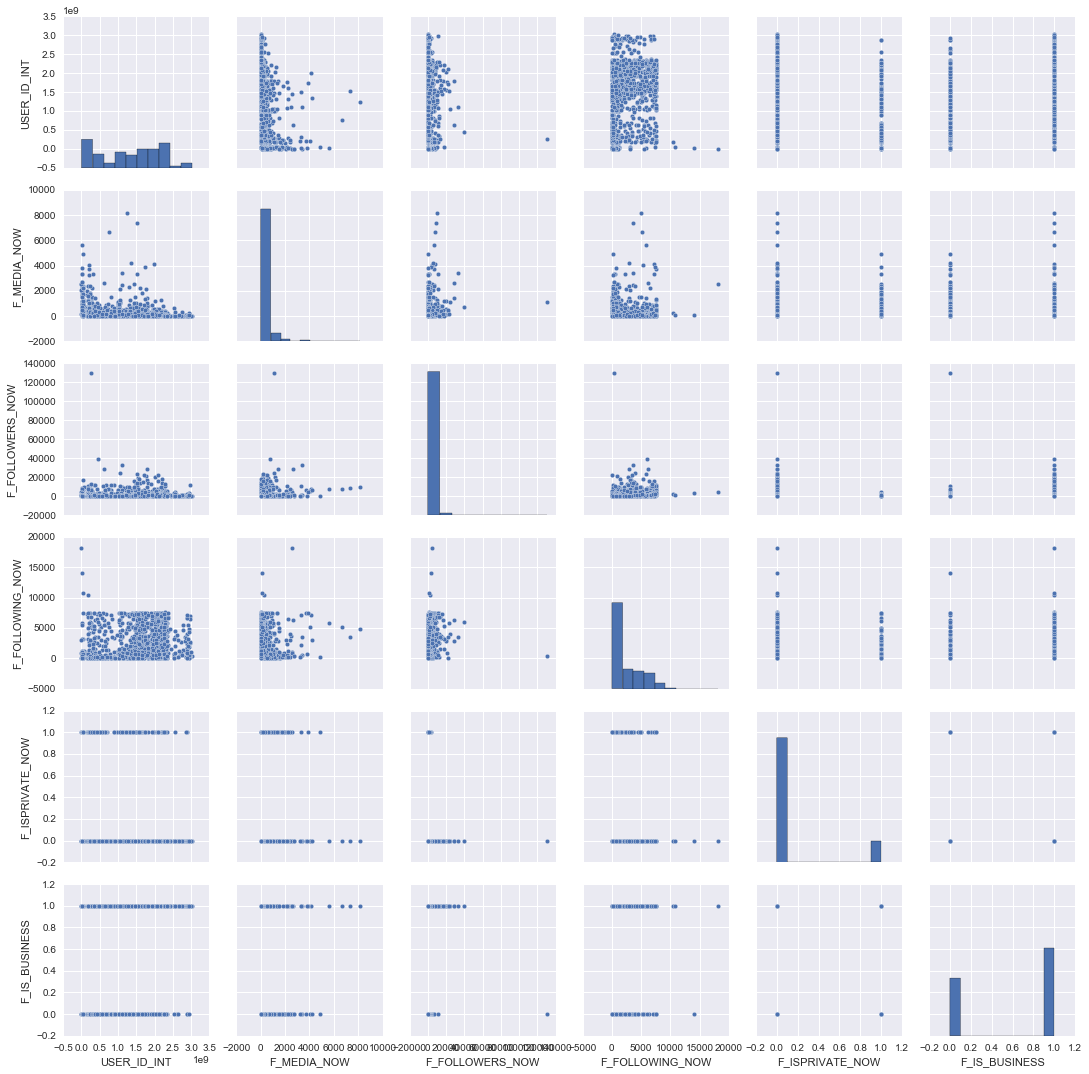

In [13]:
sns.pairplot(ig_df.loc[:,:'F_IS_BUSINESS'])

Чёткие прямоугольники в районе Following получаются, потому что ИГ не даёт аккаунтам следовать больше чем за 8000 других аккаунтов. Но когда-то было не так, оттуда остались всплески. Количество подписчиков и медиа распределены по степенному закону, но в случае подписок он немного другой и дальше мы увидим, что это не случайно.

## 4. если пришли к каким-то "инсайтам", обнаружили закономерности - изложите (это самое главное) 

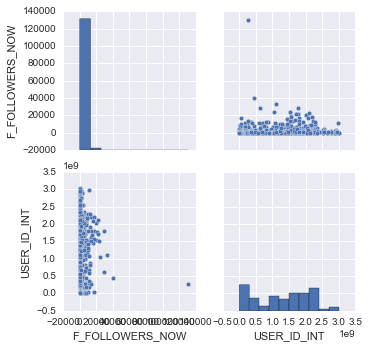

In [14]:
sns.pairplot(ig_df[['F_FOLLOWERS_NOW','USER_ID_INT']])

Тут на графике виден сходящийся к нулю треугольник. Чем моложе аккаунт, тем меньше у него постов. Но где-то начиная с середины истории (условно 2013 год) стали появляться другие аккаунты. Поэтому-то внутренний ID ИГ - это важный признак.   

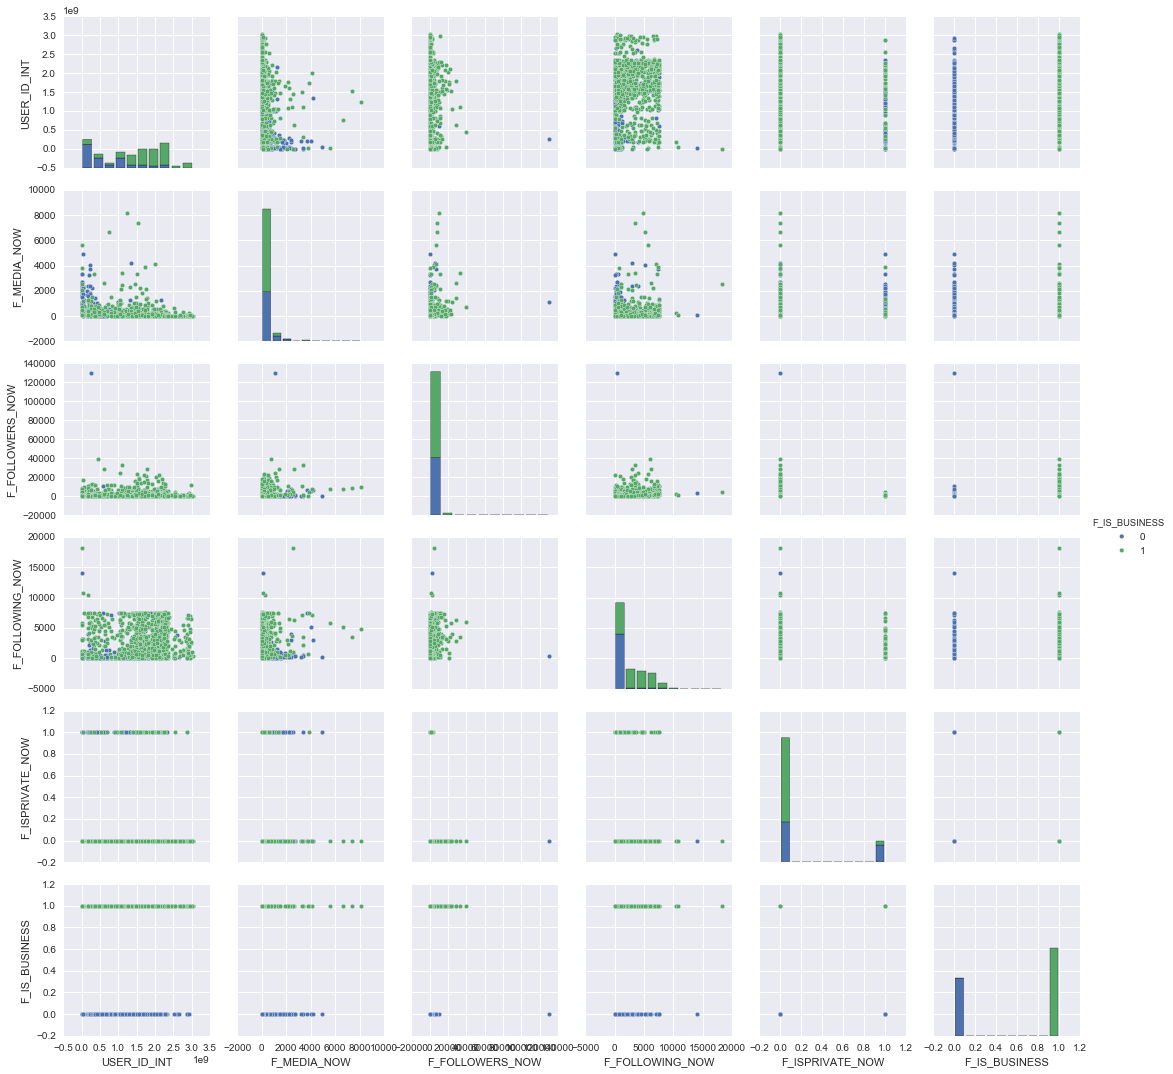

In [15]:
sns.pairplot(ig_df.loc[:,:'F_IS_BUSINESS'],hue="F_IS_BUSINESS")

при более пристальном анализе видно, что бизнес-аккаунты сильно зависят от ID и от FOLLOWING. Фактически большинство новых аккаунтов - это коммерческие аккаунты. 

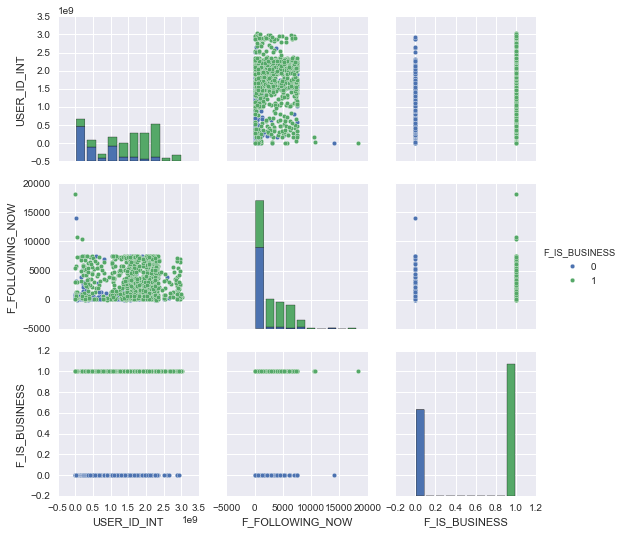

In [16]:
sns.pairplot(ig_df[['USER_ID_INT','F_FOLLOWING_NOW','F_IS_BUSINESS']],hue="F_IS_BUSINESS")

### обратите внимание на гистограммы по диагонали.

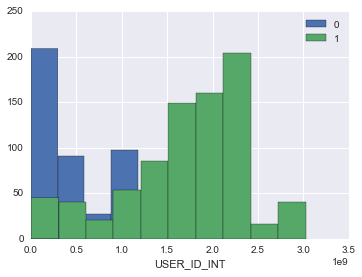

In [17]:
g = sns.FacetGrid(ig_df[['USER_ID_INT','F_IS_BUSINESS']], hue="F_IS_BUSINESS", size=4, aspect=1.3)
g.map(plt.hist, "USER_ID_INT", histtype='barstacked', stacked=True);
plt.legend();

In [18]:
def stackhist(x, y, **kws):
    grouped = pd.groupby(x, y)
    data = [d for _, d in grouped]
    labels = [l for l, _ in grouped]
    plt.hist(data, histtype="barstacked", label=labels)

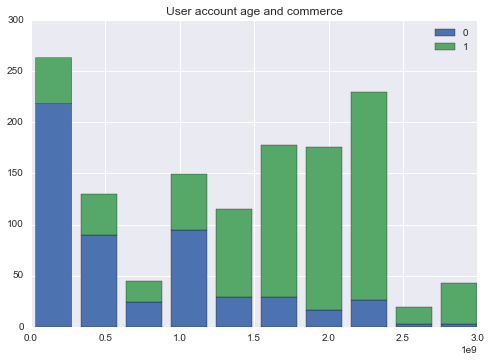

In [19]:
stackhist(ig_df.USER_ID_INT, ig_df.F_IS_BUSINESS)
plt.title("User account age and commerce")
plt.legend()

### это гистограмма по USER_ID_INT от меньшего к большему, т.е. от прошлого в будущее. Фактически коммерческие аккаунты сейчас являются основным источноком роста социальнос

## 5. Оценим важность признаков

In [20]:
X.head(3)

,USER_ID_INT,F_MEDIA_NOW,F_FOLLOWERS_NOW,F_FOLLOWING_NOW,F_ISPRIVATE_NOW
IG_USER_ID,,,,,
3C03D796-15E3-E511-827A-6451063D545C,1000046583,966,1839,1250,0
1912D796-15E3-E511-827A-6451063D545C,1001343249,57,142,91,0
19D6BE97-15E3-E511-827A-6451063D545C,1008527849,517,5851,788,0


Feature ranking:
1. feature F_FOLLOWING_NOW (0.389570)
2. feature USER_ID_INT (0.282038)
3. feature F_FOLLOWERS_NOW (0.193423)
4. feature F_MEDIA_NOW (0.105887)
5. feature F_ISPRIVATE_NOW (0.029082)


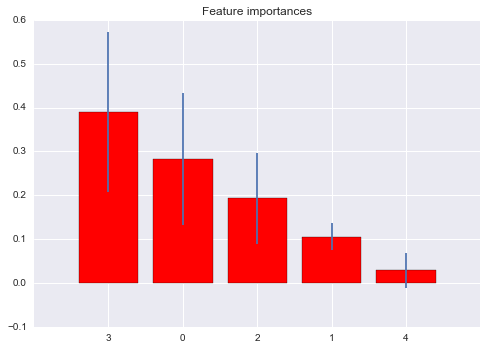

In [21]:
forest = RandomForestClassifier(n_estimators=40)

forest.fit(X,Y_biz)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

### Как и ожидалось ID оказалось очень важным признаком

## 6. Кросс-валидация

In [22]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y_biz, 
                                                    test_size=0.1, 
                                                    random_state=42,
                                                   stratify = Y_biz)

In [60]:
forest = RandomForestClassifier(n_estimators=500)
forest.fit(X_train, y_train)
test_pred = forest.predict(X_test)

In [61]:
accuracy_score(y_test, test_pred)

0.88148148148148153

In [62]:
y_test.value_counts()[0] / y_test.shape[0]

0.3925925925925926

в данном кейсе случайное предсказание работает гораздо хуже леса 

In [63]:
f1_score(y_test, test_pred)

0.90123456790123457

И f1 нам намекает, что мы на правильном пути

In [71]:
from sklearn.tree import DecisionTreeClassifier # Ваш код здесь
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [74]:
from sklearn.cross_validation import cross_val_score
import numpy as np 
from sklearn.grid_search import GridSearchCV

In [73]:
classifiers = {'st': DecisionTreeClassifier(),'rf': RandomForestClassifier(),'ada_c':AdaBoostClassifier(), \
              'gb_c':GradientBoostingClassifier(), 'ext_c':ExtraTreesClassifier()}

In [75]:
tree_params = {'min_samples_split' : list(range(1,3)),
               'max_depth': list(range(6,10)), 
               'min_samples_leaf': list(range(1,3))}

AdaBoost_params = {'n_estimators': (50,100,150)}

In [76]:
classifiers = {'st': GridSearchCV(DecisionTreeClassifier(), tree_params, verbose=True, n_jobs=-1, cv=5),\
               'rf': GridSearchCV(RandomForestClassifier(), tree_params, verbose=True, n_jobs=-1, cv=5),\
               'ada_c':GridSearchCV(AdaBoostClassifier(), AdaBoost_params, verbose=True, n_jobs=-1, cv=5), \
              'gb_c':GridSearchCV(GradientBoostingClassifier(), tree_params, verbose=True, n_jobs=-1, cv=5),\
               'ext_c':GridSearchCV(ExtraTreesClassifier(), tree_params, verbose=True, n_jobs=-1, cv=5)} 

In [77]:
clf_scores= {}

for my_clf in classifiers:
    classifiers[my_clf].fit(X_train,y_train)
    y_pred = classifiers[my_clf].predict(X_test)
    clf_scores[my_clf] = accuracy_score(y_test.as_matrix(), y_pred)
    print ("The mean %(tree)s is %(mean).3f" % {'tree': my_clf, 'mean' : clf_scores[my_clf]})

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   13.8s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits
The mean gb_c is 0.874

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   11.8s finished



Fitting 5 folds for each of 16 candidates, totalling 80 fits
The mean rf is 0.881
Fitting 5 folds for each of 3 candidates, totalling 15 fits
The mean ada_c is 0.881

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   11.7s finished



Fitting 5 folds for each of 16 candidates, totalling 80 fits
The mean ext_c is 0.874

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   11.3s finished



Fitting 5 folds for each of 16 candidates, totalling 80 fits
The mean st is 0.844


In [81]:
import operator
best_clf  = max(clf_scores.iteritems(), key=operator.itemgetter(1))[0]
print ("The best is %(tree)s with %(mean).3f with param %(par)s" % {'tree':best_clf, 'mean' : clf_scores[best_clf],
                                                                   'par':classifiers[best_clf].best_params_})

The best is rf with 0.881 with param {u'min_samples_split': 2, u'max_depth': 7, u'min_samples_leaf': 2}


Лучший у нас оказался случайный лес

In [83]:
rf_tree_params = {'n_estimators': (250, 300, 350),
                  'min_samples_split' : list(range(1,5)),
               'max_depth': list(range(6,14)), 
               'min_samples_leaf': list(range(1,5))}
n_folds = 5

In [85]:
clf = RandomForestClassifier()

grid = GridSearchCV(clf, rf_tree_params, cv=n_folds, 
                    n_jobs=-1, scoring="f1")
grid.fit(X_train, y_train)
clf_best_score = grid.best_score_
clf_best_params = grid.best_params_
clf_best = grid.best_estimator_
mean_validation_scores = []
print("Лучший результат", clf_best_score, 
      "лучшие параметры", clf_best_params)

Лучший результат 0.917408513266 лучшие параметры {u'min_samples_split': 2, u'n_estimators': 350, u'max_depth': 7, u'min_samples_leaf': 4}


## 7. Проверяем сходимость модели

In [89]:
from sklearn.learning_curve import learning_curve

In [90]:
def plot_with_std(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
        
def plot_learning_curve(clf, X, y, scoring, cv=5):
 
    train_sizes = np.linspace(0.05, 1, 20)
    n_train, val_train, val_test = learning_curve(clf,
                                                  X, y, train_sizes, cv=cv,
                                                  scoring=scoring)
    plot_with_std(n_train, val_train, label='training scores', c='green')
    plot_with_std(n_train, val_test, label='validation scores', c='red')
    plt.xlabel('Training Set Size'); plt.ylabel(scoring)
    plt.legend()

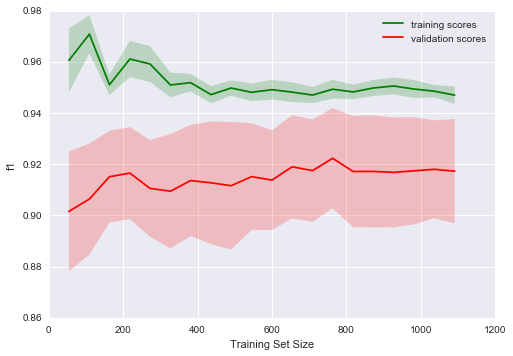

In [91]:
plot_learning_curve(RandomForestClassifier(min_samples_split=2, n_estimators=350, max_depth=7, min_samples_leaf=4),
                   X_train, y_train, scoring='f1', cv=10)

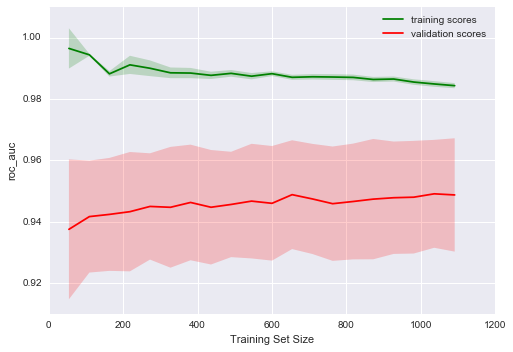

In [93]:
plot_learning_curve(RandomForestClassifier(min_samples_split=2, n_estimators=350, max_depth=7, min_samples_leaf=4),
                   X_train, y_train, scoring='roc_auc', cv=10)

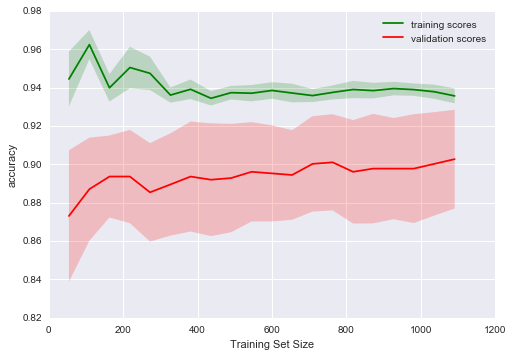

In [95]:
plot_learning_curve(RandomForestClassifier(min_samples_split=2, n_estimators=350, max_depth=7, min_samples_leaf=4),
                   X_train, y_train, scoring='accuracy', cv=10)

Согласно F1 данных достаточно, но ROC и Accuracy намекают, что данных можно было бы взять ещё. 

### Бустинг

In [94]:
from sklearn.learning_curve import validation_curve

def plot_validation_curve(clf, X, y, cv_param_name, 
                          cv_param_values, scoring):

    val_train, val_test = validation_curve(clf, X, y, cv_param_name,
                                           cv_param_values, cv=5,
                                                  scoring=scoring)
    plot_with_std(cv_param_values, val_train, 
                  label='training scores', c='green')
    plot_with_std(cv_param_values, val_test, 
                  label='validation scores', c='red')
    plt.xlabel(cv_param_name); plt.ylabel(scoring)
    plt.legend()

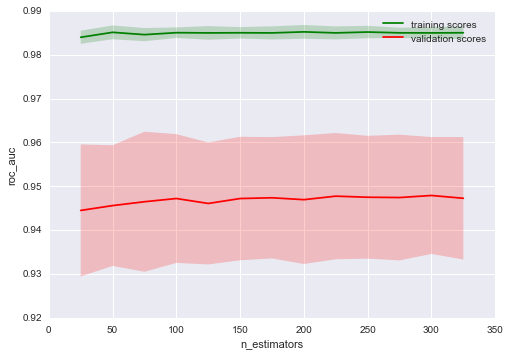

In [98]:
estimators = np.arange(25, 350, 25)
plot_validation_curve(RandomForestClassifier(min_samples_split=2, 
                                             max_depth=7, min_samples_leaf=4), X_train, y_train, 
                      cv_param_name='n_estimators', 
                      cv_param_values= estimators,
                   scoring='roc_auc')

Видно, что количество деревьев не влияет. 

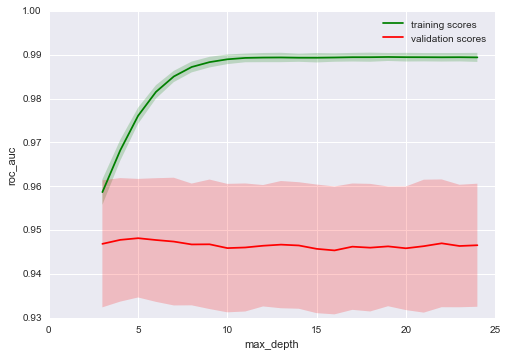

In [100]:
depth = np.arange(3, 25)
plot_validation_curve(RandomForestClassifier(min_samples_split=2, n_estimators = 350
                                             , min_samples_leaf=4), X_train, y_train, 
                      cv_param_name='max_depth', 
                      cv_param_values= depth,
                   scoring='roc_auc')

Больше 10 делать глубину нет смысла. 

In [103]:
final_forest = RandomForestClassifier(min_samples_split=2, n_estimators=350, max_depth=7, min_samples_leaf=4)
final_forest.fit(X_train, y_train)
final_pred = final_forest.predict(X_test)
accuracy_score(y_test, final_pred), f1_score(y_test, final_pred),roc_auc_score(y_test, final_pred)

(0.90370370370370368, 0.92121212121212126, 0.89737689829728495)

# Выводы

Построена модель классификации коммерческих аккаунтов в социальной сети Инстаграмм. Данная модель даёт примерно 90% точности на отложенных 10% выборки. Данный результат устойив к способу измерения погрешности, а именно достижим на метриках Accuracy, F1, ROC_AUC. 

Были построены валидационные кривые, которые говорят нам о том, что данных в количестве 1300 штук нам немного не достаёт. Сходимость дальше есть, можно собрать как минимум столько же.  

Глубина 7 найденная жадным поиском в принципе оптимальна. Дальше модель получается слегка переобучена. 

Главный инсайт в том, что данная социальная сеть продолжает свой рост в основном за счёт коммерческих аккаунтов, а не частных. Рост частных сходит на нет, а рост коммеррческих набирает обороты. А так же в том, что не заглядывая в фотографии и не читая текстов по формальным признакам можно отсекать спам в ИГ с хорошей вероятностью. Недостатком метода является то, что модели и способы работы коммерческих аккаунтов или паттерны поведения частных лиц могут существенно поменяться со временем и данная модель потеряет актуальность. 

Результаты данного исследования можно проверить любому желающему, использованные данные общедоступны.

### P.S. данная модель достоверна для русского сегмента. Выборка случайна только в пределах РФ. 